# Interactive clustering APP

In [2]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import ipywidgets as widgets
from IPython.display import display
import os

import matplotlib.pyplot as plt

## Load data

In [3]:
VaVaI_DataFrame = pd.read_csv('../data/TACR_Starfos_isvav_project.csv')
VaVaI_columns = VaVaI_DataFrame.columns.to_list()

## Define transforms

#### Preprocessing

In [4]:
# Preprocessing methods
import re
from string import punctuation
import nltk
from nltk.corpus import stopwords
import requests
from conllu import parse

def display_head(df):
    print('=========================================')
    for i in range(5):
        print(df[i][:100])
        print()

def remove_stopwords_eng(x):
    sw = stopwords.words('english')
    sw.extend(['aim', 'goal', 'attempt', 'project', 'evaluate', 'research', 'improve', 'improvement', 'development'])
    new_sentence = []
    for word in x:
        if word not in sw:
            new_sentence.append(word)
    return new_sentence

def tokenize_text(text):
    tokenizer = nltk.tokenize.WhitespaceTokenizer()
    return tokenizer.tokenize(text)

def lemmatize_text(text):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]

def ud_tokenize_lemmatize(text):
    response = requests.get(f'http://lindat.mff.cuni.cz/services/udpipe/api/process?tokenizer&tagger&parser&data={text}').json()
    response = parse(response['result'])
    lemmas = []
    for sentence in response:
        lemmas.extend([word['lemma'] for word in sentence])
    return lemmas

#### Vectorization

##### - TF-IDF

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize_using_tf_idf(data, min_n=1, max_n=5):
    result = {}
    for i in range(min_n, max_n + 1):
        for j in range(min_n, max_n + 1):
            if i > j: continue
            print(f'Fitting TF-IDF for ngram range: ({i},{j})')
            transformer = TfidfVectorizer(ngram_range=(min_n, max_n))
            print(data)
            vectorized = transformer.fit_transform(data.apply(' '.join))
            result[f'tf-idf_({i},{j})'] = vectorized
    return result

##### - Word2Vec - Pretrained

In [6]:
import gensim
from gensim.models import Word2Vec
import gensim.downloader as api

model_names = ['fasttext-wiki-news-subwords-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50',
               'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 
               'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200']

def word2vec(data, model_name):
    def document_vector(sentence):
        if len(sentence) == 0:
            return np.zeros(model.vector_size)
        doc = [word for word in sentence if word in model]
        if len(doc) == 0:
            return np.zeros(model.vector_size)
        return np.mean(model[doc], axis=0)
    
    print(f'Loading model: {model_name}')
    model = api.load(model_name)
    vectorized = data.apply(document_vector)
    return np.stack(vectorized)

def vectorize_using_pretrained_word2vec(data):
    results = {}
    for model_name in model_names:
        vectorized = word2vec(data, model_name)
        results[f'word2vec_({model_name})'] = vectorized
    return results

/home/fassty/anaconda3/envs/deep_learning/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


##### - Word2Vec

In [7]:
def word2vec_train(df, vector_size, epochs):
    def document_vector(sentence):
        if len(sentence) == 0:
            return np.zeros(model.vector_size)
        doc = np.array([model.wv[word] for word in sentence])
        if len(doc) == 0:
            return np.zeros(model.vector_size)
        return np.mean(doc, axis=0)
    
    print(f'Training Word2Vec model with vector size {vector_size} for {epochs}')
    data = df.to_list()
    model = Word2Vec(sentences=data, vector_size=vector_size, window=5, min_count=1, workers=4, epochs=epochs)
    model.save(f'word2vec_{vector_size}_{epochs}')
    
    vectorized = df.apply(document_vector)
    return np.stack(vectorized)

def vectorize_using_word2vec(data):
    results = {}
    for vs in [25, 50, 100, 200]:
        for ep in [10, 25, 50, 100]:
            vectorized = word2vec_train(data, vs, ep)
            results[f'word2vec_{vs}_{ep}'] = vectorized
    return results

##### - Doc2Vec

In [8]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

def doc2vec_train(data, vector_size, epochs):
    print(f'Training Doc2Vec model with vector size {vector_size} for {epochs} epochs')
    model = Doc2Vec(documents=data, 
                    vector_size=vector_size, 
                    window=5, 
                    min_count=1, 
                    workers=8,
                    hs=1,
                    epochs=epochs)
    model.save(f'doc2vec_{vector_size}_{epochs}')
    return np.array([model.dv[i] for i in range(len(data))])

def vectorize_using_doc2vec(data):
    results = {}
    tagged_data = [TaggedDocument(words=sentence, tags=[index]) for sentence, index in zip(data, list(data.index))]
    for vs in [25, 50, 100, 200, 300]:
        for ep in [10, 50, 100, 150]:
            vectorized = doc2vec_train(tagged_data, vs, ep)
            results[f'doc2vec_{vs}_{ep}'] = vectorized
    return results

#### Evaluation

In [9]:
from pyclustertend import hopkins

def calc_hopkins_score(vector):
    if hasattr(vector, 'toarray'):
        vector = vector.toarray()
    df = pd.DataFrame(vector)
    hs = hopkins(df, vector.shape[0])
    return hs

def eval_using_hopkins_test(results_dir, results):
    with open(os.path.join(results_dir, 'hopkins.txt'), 'w') as handle:
        for name, vector in results.items():
            if vector.shape[0] * vector.shape[1] >= 1e8:
                print('Vector too large, skipping.')
                continue
            hs = calc_hopkins_score(vector)
            handle.write(f'Hopkins score for {name}: {hs:5f}\n')

#### Cluster

In [10]:
from nltk.cluster import KMeansClusterer, euclidean_distance, cosine_distance
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

def cluster_using_kmeans(data, ax):
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=(1, 40), ax=ax)
    visualizer.fit(data)

def visualize_kmeans_results(results_dir, results):
    height = len(results) * 20
    fig, axes = plt.subplots(len(results), figsize=(12, height))

    for idx, (name, vector) in enumerate(results.items()):
        print(f'Fitting elbow for {name}')
        cluster_using_kmeans(vector, axes[idx])
        axes[idx].set_title(f'KMeans Elbow for {name}')
        axes[idx].set_xticks(list(range(40)))

    plt.savefig(os.path.join(results_dir, 'kmeans_elbow.png'))

#### Widgets

In [11]:
# Data source
datasource_select = widgets.ToggleButtons(
    options=['Generate', 'Load'],
    description='Data:',
    disabled=False,
    button_style='',
    tooltips=['Load all projects and generate data', 'Load processed data from file'],
    icons=['check'] * 2)
data_source_widget = widgets.HBox([datasource_select])

# Columns
multisel_columns = widgets.SelectMultiple(
    options=VaVaI_columns,
    disabled=False,
    rows=20,
)
col_select_button = widgets.Button(description='Select column(s)', icon='table')
columns_widget = widgets.VBox([multisel_columns, col_select_button])

# Transforms
transforms = {
    'Remove stopwords': remove_stopwords_eng,
    'Tokenize': tokenize_text,
    'Lemmatize': lemmatize_text,
    'UDPipe': ud_tokenize_lemmatize
}
multisel_transforms = widgets.SelectMultiple(
    options=list(transforms.keys()),
    disabled=False,
    rows=10,
)
trans_select_button = widgets.Button(description='Select Transforms', icon='table')
trans_widget = widgets.VBox([multisel_transforms, trans_select_button])

# Models
models = {
    'TF-IDF': vectorize_using_tf_idf,
    'Word2Vec-Pretrained': vectorize_using_pretrained_word2vec,
    'Word2Vec': vectorize_using_word2vec,
    'Doc2Vec': vectorize_using_doc2vec
}
multisel_models = widgets.SelectMultiple(
    options=list(models.keys()),
    disabled=False,
    rows=10,
)
model_select_button = widgets.Button(description='Select Models', icon='table')
model_widget = widgets.VBox([multisel_models, model_select_button])

selections_widget = widgets.HBox([columns_widget, trans_widget, model_widget])

widgets.VBox([data_source_widget, selections_widget])

In [69]:
import pickle

RESULTS_DIR = 'ud_pipe_czech_text'

if datasource_select.value == 'Generate': 
    selected_columns = list(multisel_columns.value)
    selected_columns_df = VaVaI_DataFrame[selected_columns]
    
    # Clean the data
    nan_rows = selected_columns_df.isna().any(axis=1)
    cleaned_df = selected_columns_df[~nan_rows]

    # Pair with the original df for future reference
    VaVaI_DataFrame = VaVaI_DataFrame.iloc[cleaned_df.index]
    cleaned_df.reset_index(inplace=True)
    VaVaI_DataFrame.reset_index(inplace=True, drop=True)
    display(cleaned_df.head())
    print(f'Number of rows after cleaning: {len(cleaned_df)}')

    del selected_columns_df
    processed_data = cleaned_df.apply(' '.join, axis=1).astype(str)
    
    for transform_name, transform in multisel_transforms.items():
        processed_data = processed_data.apply(transform)
        display_head(processed_data)
else:
    processed_data = pd.read_csv('nazev_anotace_lemmatized.csv')
    print(f'Loaded {len(processed_data)} rows of data')
    processed_data = processed_data['text']
    processed_data = processed_data.apply(lambda x: re.sub('\'', '', x))\
                                   .apply(lambda x: re.sub('\s', '', x))\
                                   .apply(lambda x: x[1:-1].split(','))
    def remove_punctuation(arr):
        return [w for w in arr if w not in punctuation]
    
    def remove_stopwords(arr):
        from stop_words import get_stop_words
        sw = get_stop_words('cz') + ['a', 'v', 's', 'i', 'o', 'k', 'z', 'se', 'ze', 'na', 'projekt']
        return [w for w in arr if w not in sw]
            
    processed_data = processed_data.apply(remove_punctuation)
    processed_data = processed_data.apply(remove_stopwords)
    display_head(processed_data)

selected_models = list(multisel_models.value)
print(f'Using models: {selected_models}')

results = {}
for model in selected_models:
    results = {**results, **models[model](processed_data)}

save_dir = os.path.join('saved_models', RESULTS_DIR)
os.makedirs(save_dir, exist_ok=True)

with open(os.path.join(save_dir, 'vectors.pickle'), 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

eval_using_hopkins_test(save_dir, results)

visualize_kmeans_results(save_dir, results)

Loaded 53399 rows of data
['účast', 'uroaktivní', 'steroid', 'mužský', 'reprodukce', 'předmět', 'být', 'studium', 'účast', 'uroaktivní', 'steroid', 'pregnenolon', 'isomer', 'pregnanolon', 'spouštění', 'průběh', 'mužský', 'orgasmus', 'ejakulace', 'jako', 'podklad', 'možný', 'léčba', 'porucha', 'tento', 'komponenta', 'mužský', 'pohlavní', 'akt']

['zkvalitnění', 'péče', 'pacient', 'cystický', 'fibróza', 'včasný', 'efektivní', 'diagnostika', 'pomocí', 'dvoustupňový', 'novorozenecký', 'screening', 'cíl', 'být', 'ověření', 'efektivita', 'proveditelnost', 'účinnost', 'novorozenecký', 'screening', 'cystický', 'fibróza', 'podmínka', 'český', 'republika', 'metoda', 'být', 'měření', 'koncentrace', 'imunoreaktivní', 'trypsin', 'následný', 'genový', 'analýza', 'suchý', 'kapka', 'krev']

['molekulárně', 'cytogenetický', 'analýza', 'buňka', 'mozkový', 'tumor', 'přínos', 'diagnostika', 'léčba', 'molekulárně', 'cytogenetický', 'studie', 'signifikantní', 'skupina', 'nemocný', 'mozkový', 'tumor', 'sledo

FileNotFoundError: [Errno 2] No such file or directory: 'saved_models/ud_pipe_czech_text/vectors.pickle'

Fitting elbow for word2vec_25_10
Fitting elbow for word2vec_25_25
Fitting elbow for word2vec_25_50
Fitting elbow for word2vec_25_100
Fitting elbow for word2vec_50_10
Fitting elbow for word2vec_50_25
Fitting elbow for word2vec_50_50
Fitting elbow for word2vec_50_100
Fitting elbow for word2vec_100_10
Fitting elbow for word2vec_100_25
Fitting elbow for word2vec_100_50
Fitting elbow for word2vec_100_100
Fitting elbow for word2vec_200_10
Fitting elbow for word2vec_200_25
Fitting elbow for word2vec_200_50
Fitting elbow for word2vec_200_100
Fitting elbow for doc2vec_25_10
Fitting elbow for doc2vec_25_50
Fitting elbow for doc2vec_25_100
Fitting elbow for doc2vec_25_150
Fitting elbow for doc2vec_50_10
Fitting elbow for doc2vec_50_50
Fitting elbow for doc2vec_50_100
Fitting elbow for doc2vec_50_150
Fitting elbow for doc2vec_100_10
Fitting elbow for doc2vec_100_50
Fitting elbow for doc2vec_100_100
Fitting elbow for doc2vec_100_150
Fitting elbow for doc2vec_200_10
Fitting elbow for doc2vec_200_50


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


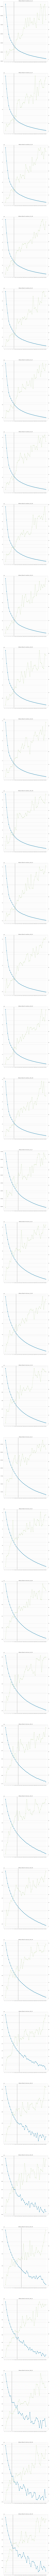

In [70]:
os.makedirs(save_dir, exist_ok=True)

with open(os.path.join(save_dir, 'vectors.pickle'), 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

eval_using_hopkins_test(save_dir, results)

visualize_kmeans_results(save_dir, results)

"['účast', 'uroaktivní', 'steroid', 'na', 'mužský', 'reprodukce', 'předmět', 'projekt', 'být', 'studium', 'účast', 'uroaktivní', 'steroid', '(', 'pregnenolon', 'a', 'isomer', 'pregnanolon', ')', 'na', 'spouštění', 'a', 'průběh', 'mužský', 'orgasmus', 'a', 'ejakulace', 'jako', 'podklad', 'k', 'možný', 'léčba', 'porucha', 'tento', 'komponenta', 'mužský', 'pohlavní', 'akt', '.']"

FileUpload(value={}, description='Upload data:')


## Filter columns

In [3]:
multisel_columns = widgets.SelectMultiple(
    options=VaVaI_columns,
    disabled=False,
    rows=20,
)

select_button = widgets.Button(description='Select column(s)', icon='table')
columns_widget = widgets.VBox([multisel_columns, select_button])

Název česky  \
0  Účast neuroaktivních steroidů na mužské reprod...   
1  Zkvalitnění péče o pacienty s cystickou fibróz...   
2  Molekulárně cytogenetická analýza buněk mozkov...   
3  Modelování potenciálně antimykobakteriálně akt...   
4  Rozvoj aplikací DNA čipů pro potřeby diagnosti...   

                                       Anotace česky  
0  Předmětem projektu je studium účasti neuroakti...  
1  Cílem je ověření efektivity (proveditelnosti a...  
2  Molekulárně cytogenetická studie signifikantní...  
3  Syntéza nových potenciálně antimykobakteriálně...  
4  Aplikace DNA čipů by měly významným způsobem p...

## Preprocess data
- concat
- convert to lowercase
- remove punctuation
- tokenize
- remove stop-words

In [16]:
df = pd.read_csv('nazev_anotace_lemmatized.csv')

Unnamed: 0                                               text
0               0  ['účast', 'uroaktivní', 'steroid', 'na', 'mužs...
1               1  ['zkvalitnění', 'péče', 'o', 'pacient', 's', '...
2               2  ['molekulárně', 'cytogenetický', 'analýza', 'b...
3               3  ['modelování', 'potenciálně', 'antimykobakteri...
4               4  ['rozvoj', 'aplikace', 'DNA', 'čip', 'pro', 'p...
...           ...                                                ...
53394       53394  ['obnova', 'biodiverzita', 'a', 'stabilita', '...
53395       53395  ['geodynamický', 'model', 'styk', 'český', 'ma...
53396       53396  ['vývoj', 'zemský', 'kůra', 'v', 'západní', 'č...
53397       53397  ['využití', 'moderní', 'letecký', 'metoda', 'p...
53398       53398  ['komplexní', 'zhodnocení', 'geofaktor', 'živo...

[53399 rows x 2 columns]

## Vectorize
- TF-IDF
- Word2Vec
- Doc2Vec

/home/fassty/anaconda3/envs/deep_learning/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [ ]:
import pickle

selected_models = list(multisel_models.value)
print(selected_models)
sampled_data = processed_data.sample(n=1000, random_state=42)

results = {}
for model in selected_models:
    results = {**results, **models[model](processed_data)}
    
with open('vectors.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

['TF-IDF', 'Word2Vec', 'Doc2Vec']
Fitting TF-IDF for ngram range: (1,1)
Fitting TF-IDF for ngram range: (1,2)
Fitting TF-IDF for ngram range: (1,3)
Fitting TF-IDF for ngram range: (1,4)
Fitting TF-IDF for ngram range: (1,5)
Fitting TF-IDF for ngram range: (2,2)
Fitting TF-IDF for ngram range: (2,3)
Fitting TF-IDF for ngram range: (2,4)
Fitting TF-IDF for ngram range: (2,5)
Fitting TF-IDF for ngram range: (3,3)
Fitting TF-IDF for ngram range: (3,4)
Fitting TF-IDF for ngram range: (3,5)
Fitting TF-IDF for ngram range: (4,4)
Fitting TF-IDF for ngram range: (4,5)
Fitting TF-IDF for ngram range: (5,5)
Training Word2Vec model with vector size 25 for 10
Training Word2Vec model with vector size 25 for 25
Training Word2Vec model with vector size 25 for 50
Training Word2Vec model with vector size 25 for 100
Training Word2Vec model with vector size 50 for 10
Training Word2Vec model with vector size 50 for 25
Training Word2Vec model with vector size 50 for 50
Training Word2Vec model with vector si

In [35]:
#TODO: remove this cell after testing
model = Doc2Vec.load('word2vec_200')

print(processed_data[0])
vec = model.infer_vector(processed_data[0])

similar = model.docvecs.most_similar([vec])

display(similar)

['frekvence', 'distribuce', 'inzulinorezistence', 'jako', 'rizikového', 'faktoru', 'kardiovaskulárních', 'metabolických', 'onemocněni', 'stanovení', 'jednoduchých', 'kvantitativních', 'indexů', 'homa', 'ir', 'quicki', 'u', 'skupin', 'osob', 'intolerancí', 'glukózy', 'diabetem', 'typu', '2', 'hyperlipidémií', 'obezitou', 'hypertenzí', 'kombinací', 'faktorů', 'srovnání', 'se', 'zdravými', 'jedinci', 'pro', 'posouzení', 'časného', 'stádia', 'inzulínové', 'rezistencepokus', 'stanovení', 'hraniční', 'hodnoty', 'která', 'odlišovala', 'osoby', 'rizikem', 'inzulínové', 'rezistence', 'osoby', 'bez', 'rizika', 'fb', 'endokrinologie', 'diabetologie', 'metabolismus', 'výživa', 'univerzita', 'palackého', 'v', 'olomouci', 'lékařská', 'fakulta', 'parent', 'ičo', '61989592', 'prof', 'mudr', 'vladimír', 'janout', 'csc', 'vedidk', '2512343', 'orcid', '0000', '0002', '1163', '0361', 'mz', 'ministerstvo', 'zdravotnictví']


AttributeError: 'Word2Vec' object has no attribute 'infer_vector'

## Cluster
- KMeans
- Hiearchical

Hopkins score for word2vec_25_10: 0.177169
Hopkins score for word2vec_25_25: 0.188311
Hopkins score for word2vec_25_50: 0.184769
Hopkins score for word2vec_25_100: 0.182836
Hopkins score for word2vec_50_10: 0.181696
Hopkins score for word2vec_50_25: 0.190929
Hopkins score for word2vec_50_50: 0.190229
Hopkins score for word2vec_50_100: 0.189133
Hopkins score for word2vec_100_10: 0.180715
Hopkins score for word2vec_100_25: 0.194050
Hopkins score for word2vec_100_50: 0.193722
Hopkins score for word2vec_100_100: 0.192426
Hopkins score for word2vec_200_10: 0.176429
Hopkins score for word2vec_200_25: 0.194508
Hopkins score for word2vec_200_50: 0.200362
Hopkins score for word2vec_200_100: 0.198815


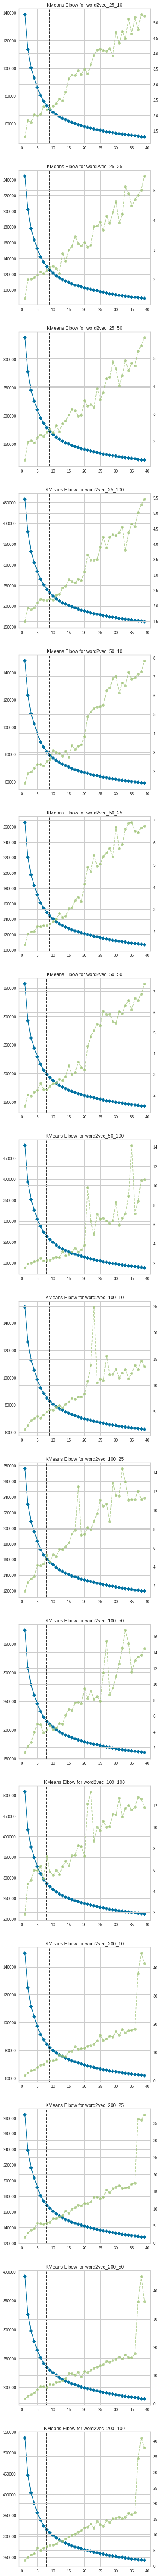

In [82]:

plt.show()

## Evaluate & Visualize clustering

In [1]:
multisel_models = widgets.Select(
    options=list(results.keys()),
    disabled=False,
    rows=10,
)

select_button = widgets.Button(description='Select Model', icon='table')

widgets.VBox([multisel_models, select_button])

NameError: name 'widgets' is not defined

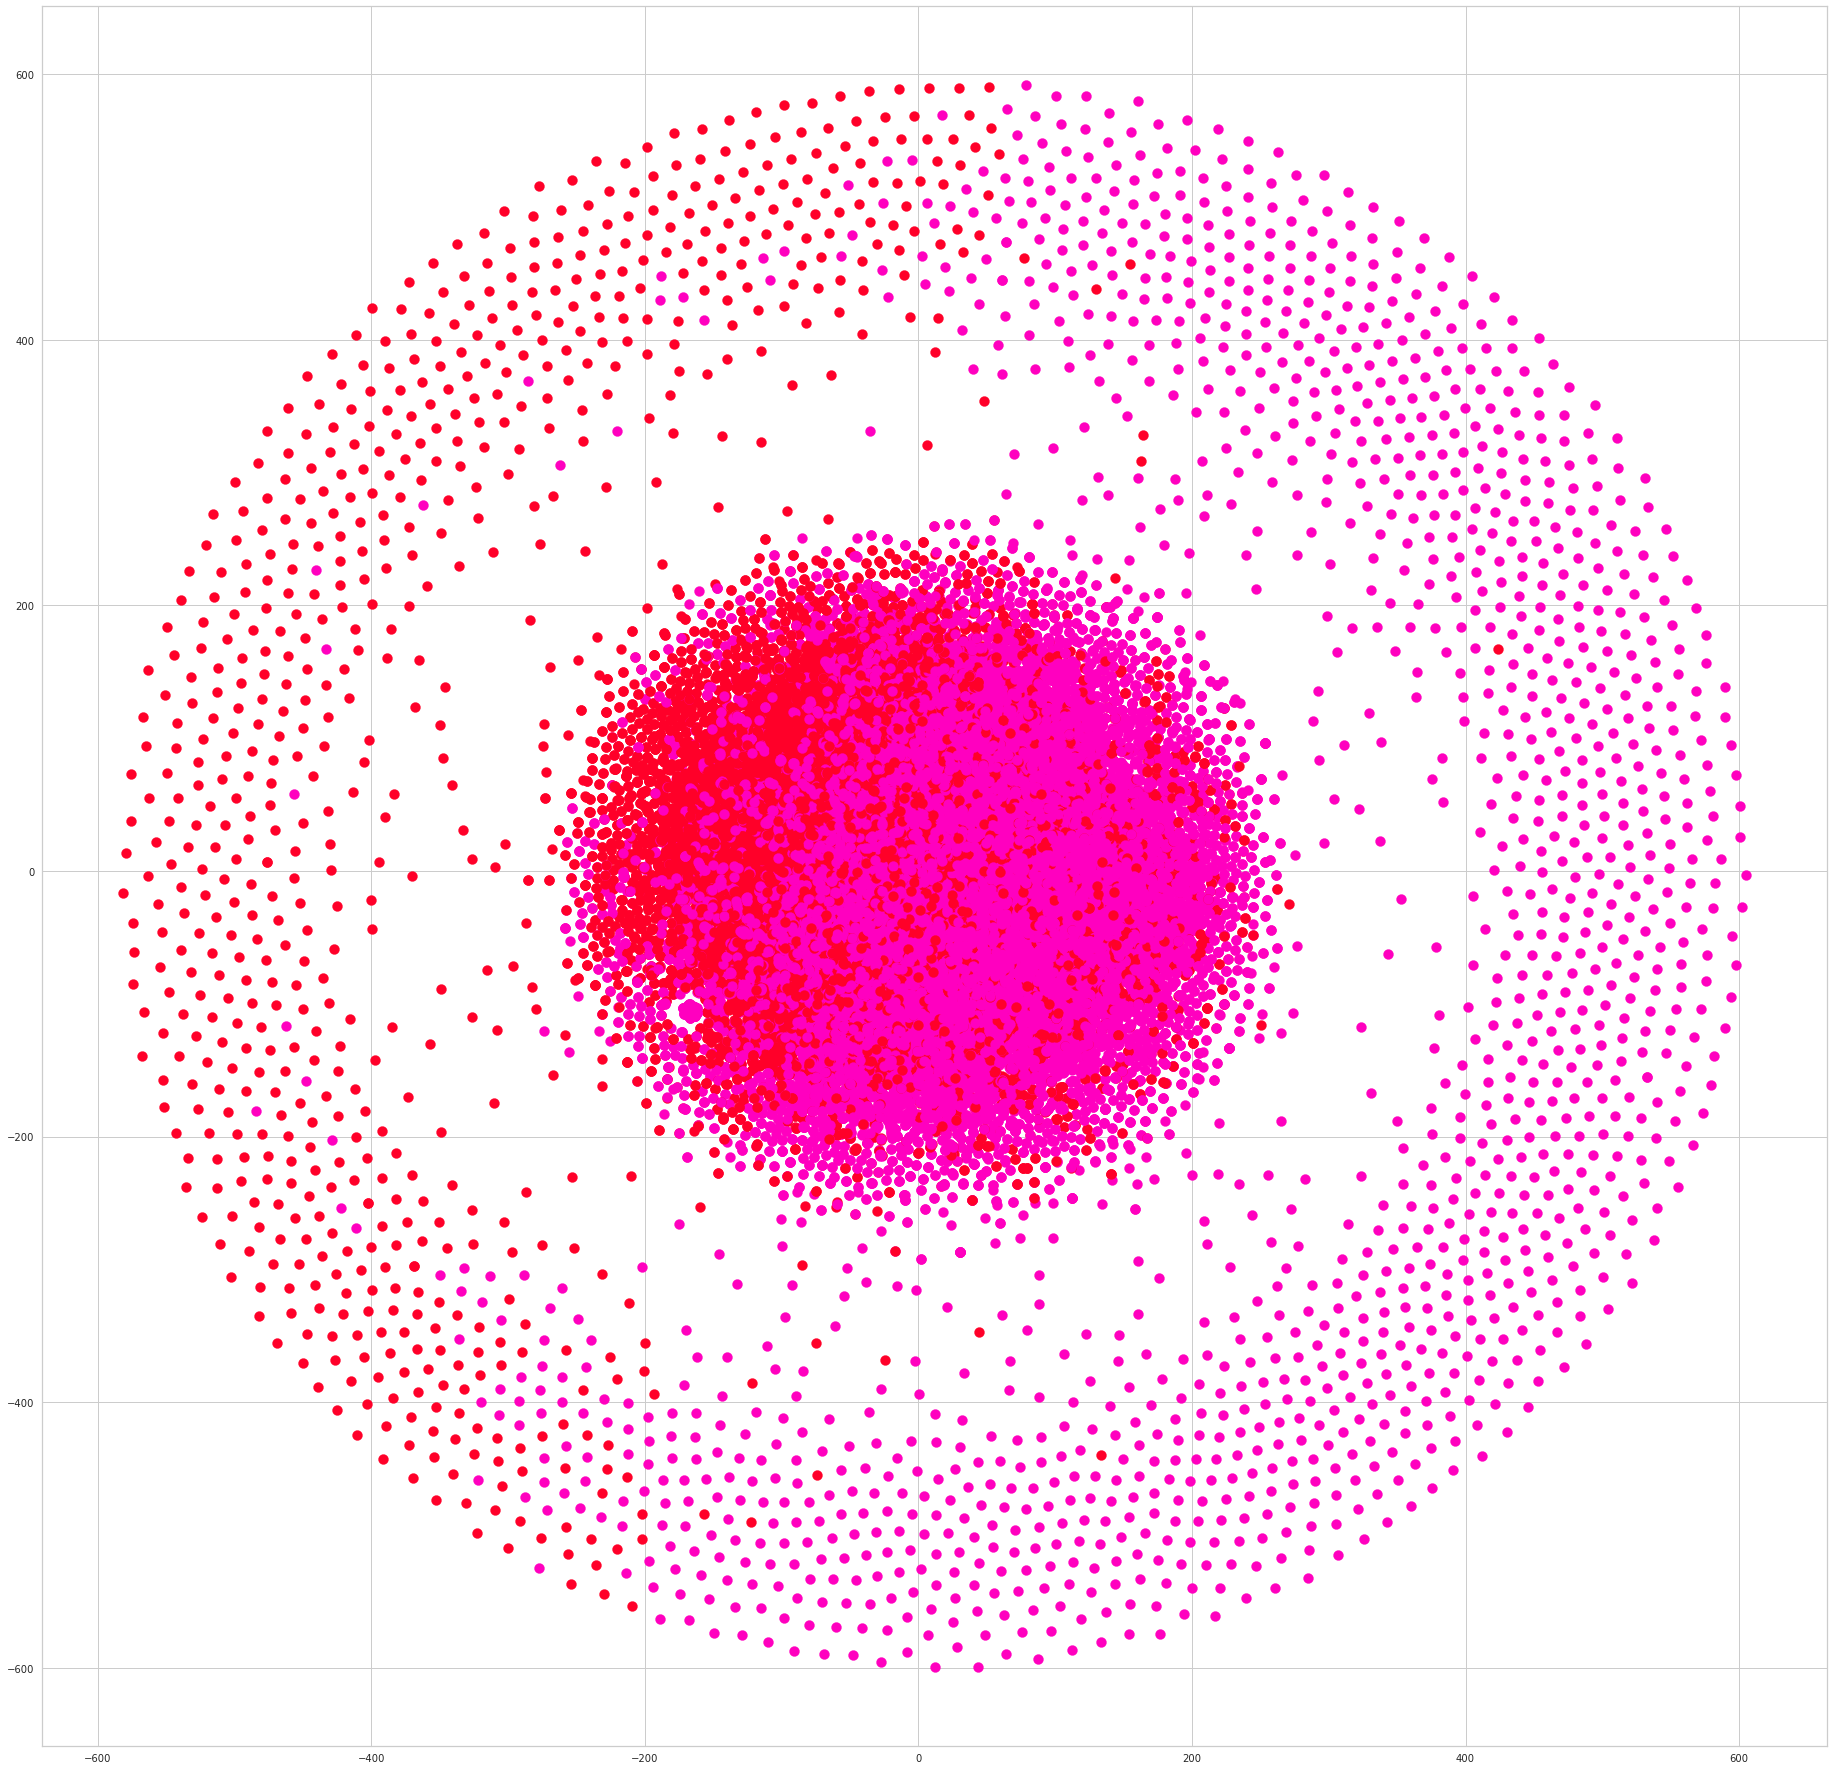

In [78]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm


def visualize_clusters(vector, n_classes):
    z = np.arange(n_classes)
    ys = [i+z+(i*z)**2 for i in range(n_classes)]
    colors = cm.gist_rainbow(np.linspace(0, 1, len(ys)))
    
    clusterer = KMeansClusterer(n_classes, euclidean_distance)
    clustered = clusterer.cluster(vector, assign_clusters=True)
    
    tsne_model = TSNE(perplexity=5, n_components=2, init='pca', n_iter=25000, random_state=23, n_jobs=-1)
    tsne_clusters = tsne_model.fit_transform(vector)
    
    x = []
    y = []
    for value in tsne_clusters:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(32, 32)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i], color=colors[clustered[i]], s=100)
    
visualize_clusters(results['doc2vec_100_100'], 2)

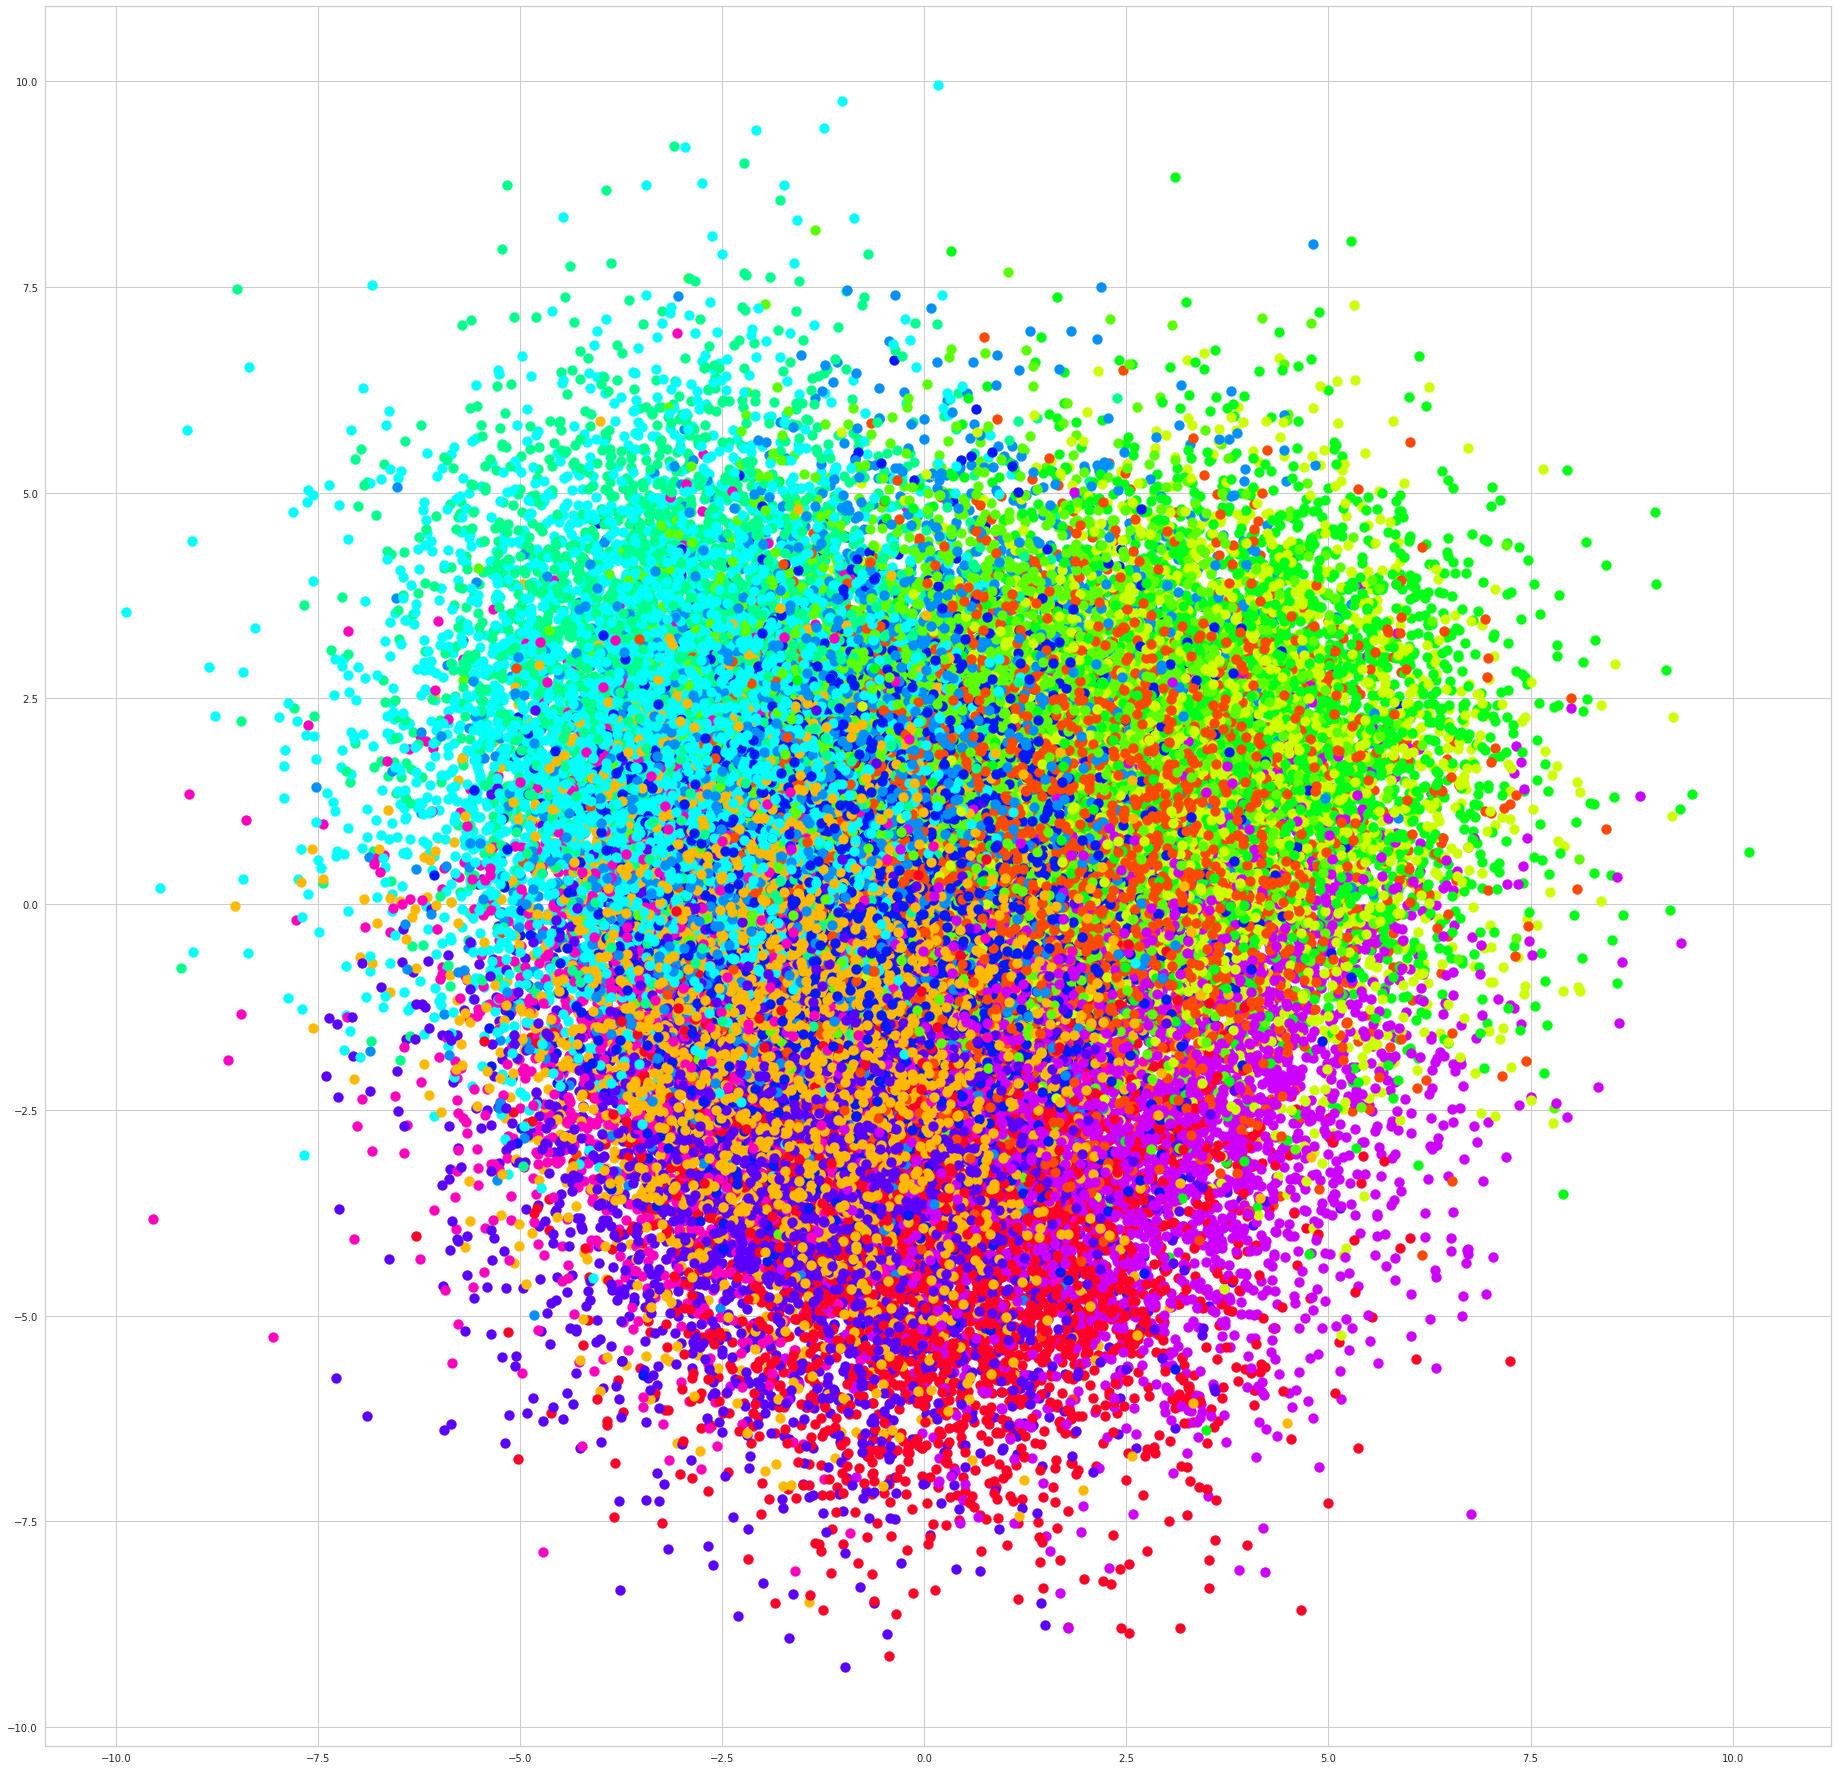

In [77]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.cm as cm

vector = results['doc2vec_100_100']
n_classes = 13
z = np.arange(n_classes)
ys = [i+z+(i*z)**2 for i in range(n_classes)]
colors = cm.gist_rainbow(np.linspace(0, 1, len(ys)))

clusterer = KMeansClusterer(n_classes, euclidean_distance)
clustered = clusterer.cluster(vector, assign_clusters=True)

tsne_model = PCA(n_components=2)
tsne_clusters = tsne_model.fit_transform(vector)

x = []
y = []
for value in tsne_clusters:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(32, 32)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i], color=colors[clustered[i]], s=100)


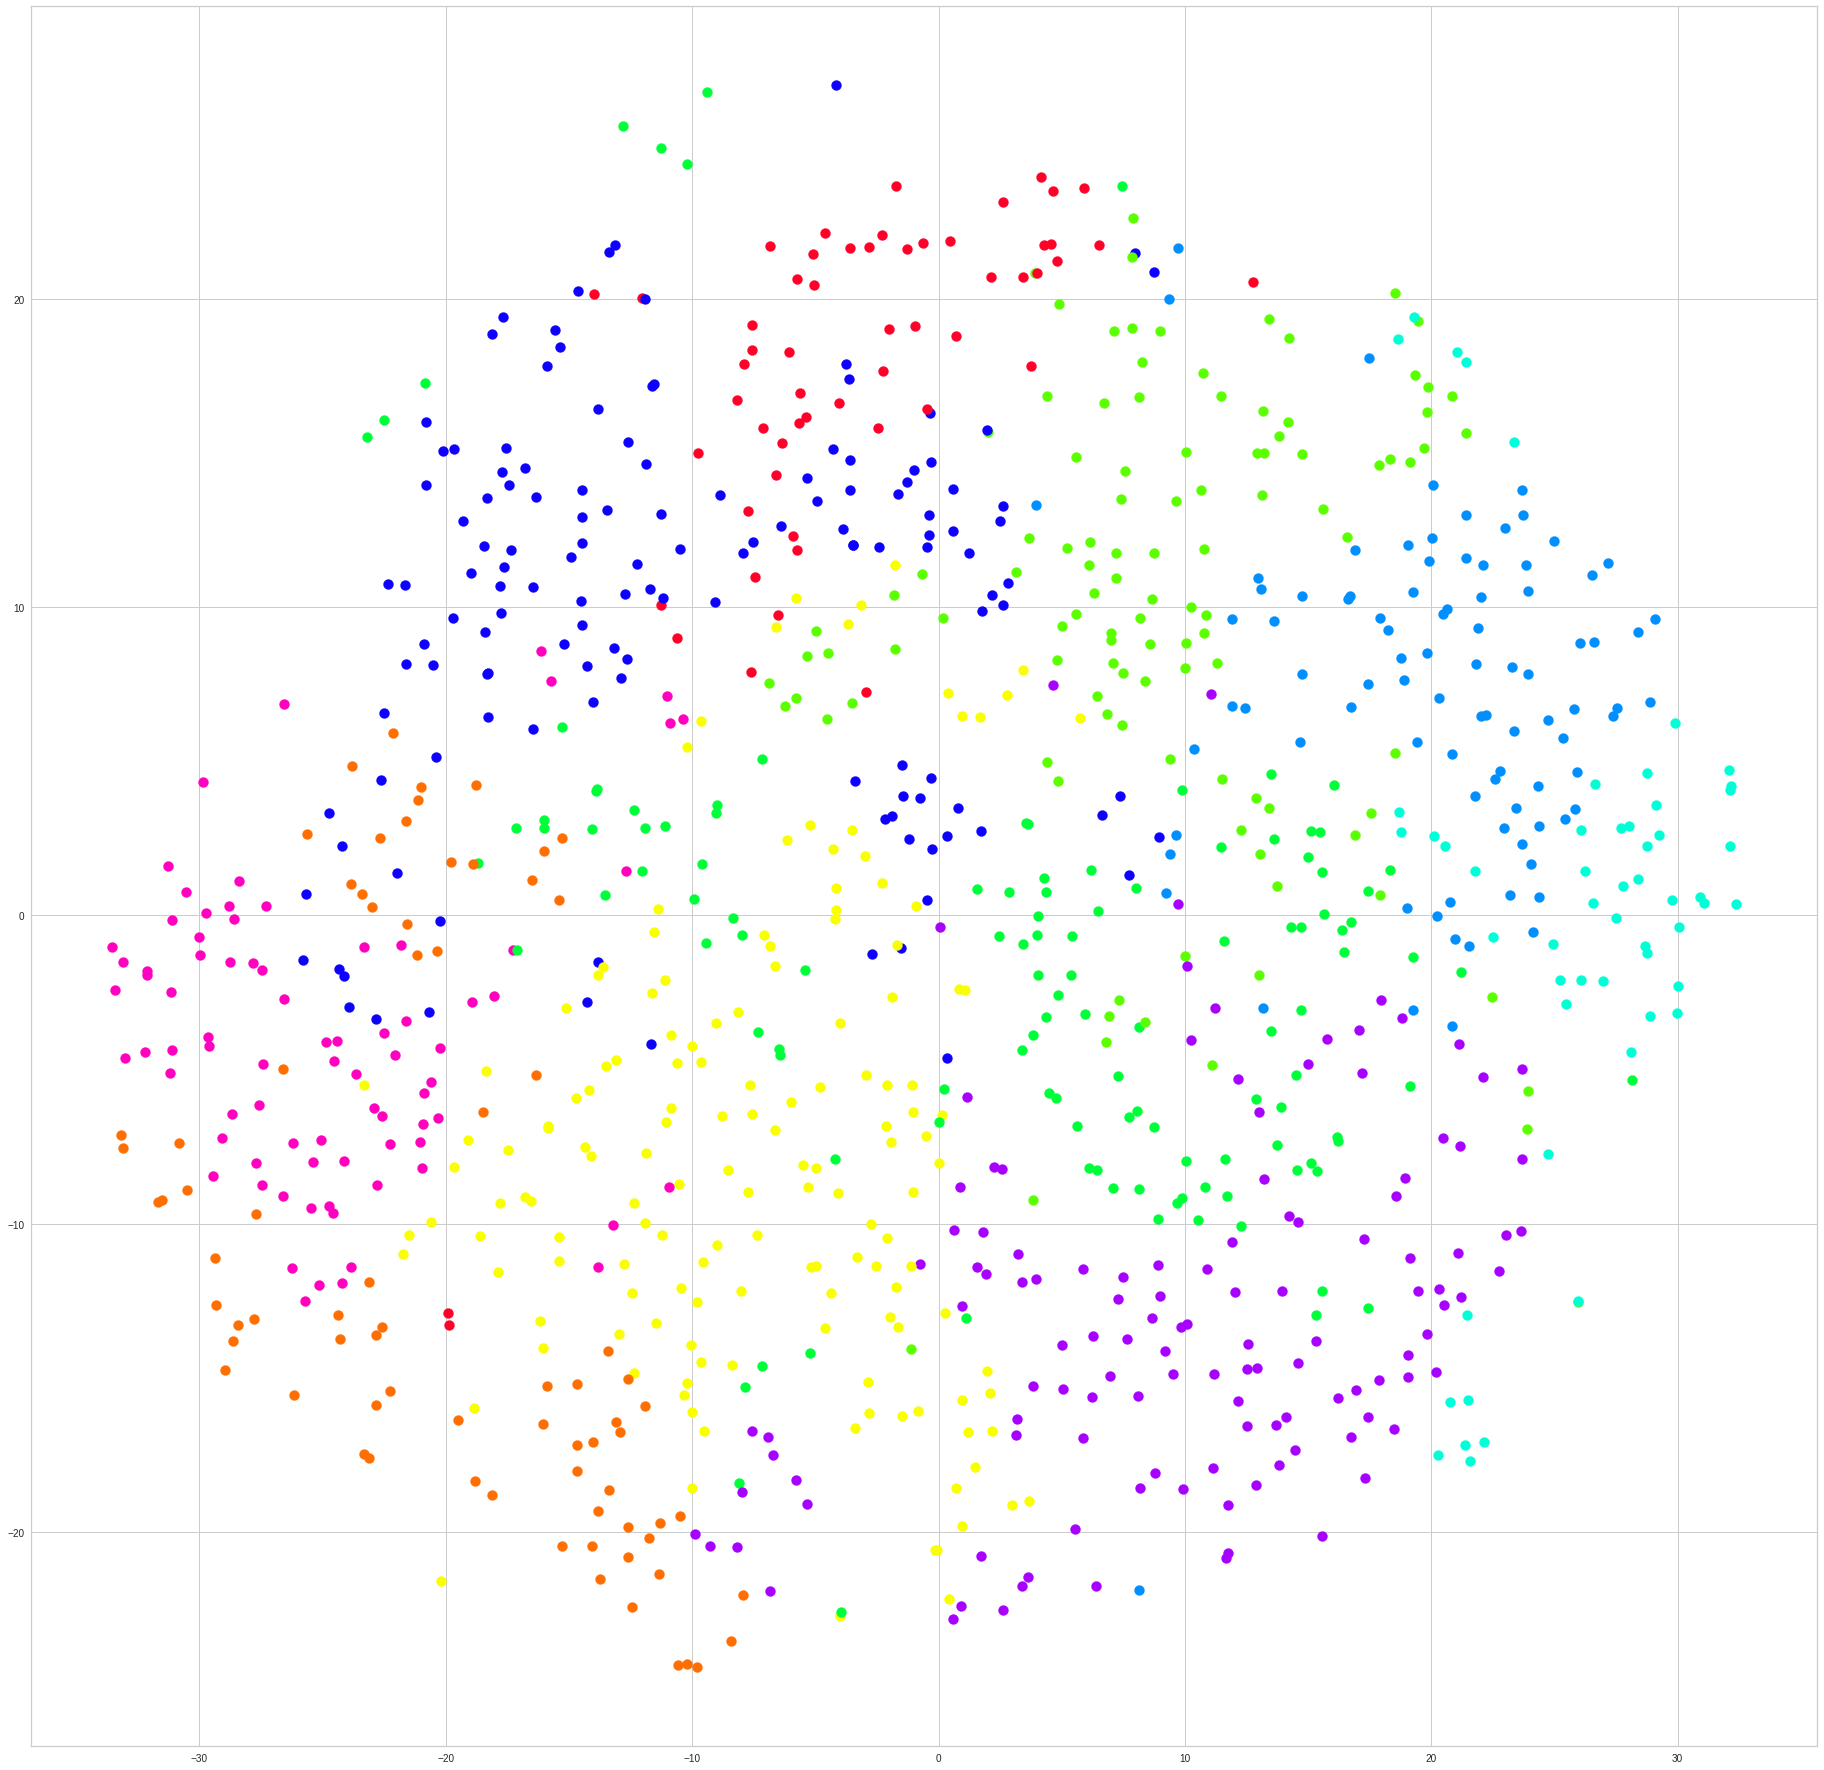

In [115]:
visualize_clusters(res[multisel_models.value])

In [125]:
hopkins(pd.DataFrame(res[multisel_models.value]), res[multisel_models.value].shape[0])

0.1807210840577872

In [12]:
import pickle
with open('saved_models/ud_pipe_czech_text/vectors.pickle', 'rb') as handle:
    vectors = pickle.load(handle)

In [22]:
from sklearn.cluster import AffinityPropagation
sample = vectors['word2vec_25_100'][np.random.choice(vectors['word2vec_25_100'].shape[0], 10000, replace=False), :]
clustering = AffinityPropagation(random_state=42, damping=0.9).fit(sample)

len(clustering.cluster_centers_)
KElbowVisualizer()

319

In [21]:
len(VaVaI_DataFrame['Poskytovatel'].unique())

29

For n_clusters = 2 The average silhouette_score is : 0.16789824374671916
For n_clusters = 3 The average silhouette_score is : 0.16856352391636037
For n_clusters = 4 The average silhouette_score is : 0.18869703560374118
For n_clusters = 5 The average silhouette_score is : 0.15614934791509386
For n_clusters = 6 The average silhouette_score is : 0.14983226522570497
For n_clusters = 7 The average silhouette_score is : 0.13811259668556689
For n_clusters = 8 The average silhouette_score is : 0.13682037300721456
For n_clusters = 9 The average silhouette_score is : 0.13224343940475858
For n_clusters = 10 The average silhouette_score is : 0.13575914610181009
For n_clusters = 11 The average silhouette_score is : 0.13541456530613735
For n_clusters = 12 The average silhouette_score is : 0.1299877321295533
For n_clusters = 13 The average silhouette_score is : 0.131679580155502
For n_clusters = 14 The average silhouette_score is : 0.12249889710369664
For n_clusters = 15 The average silhouette_score 

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_fast._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt


For n_clusters = 16 The average silhouette_score is : 0.125154179837116
For n_clusters = 17 The average silhouette_score is : 0.11815132130057718
For n_clusters = 18 The average silhouette_score is : 0.11822286595563264


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_fast._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_fast._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_fast._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt


KeyboardInterrupt: 

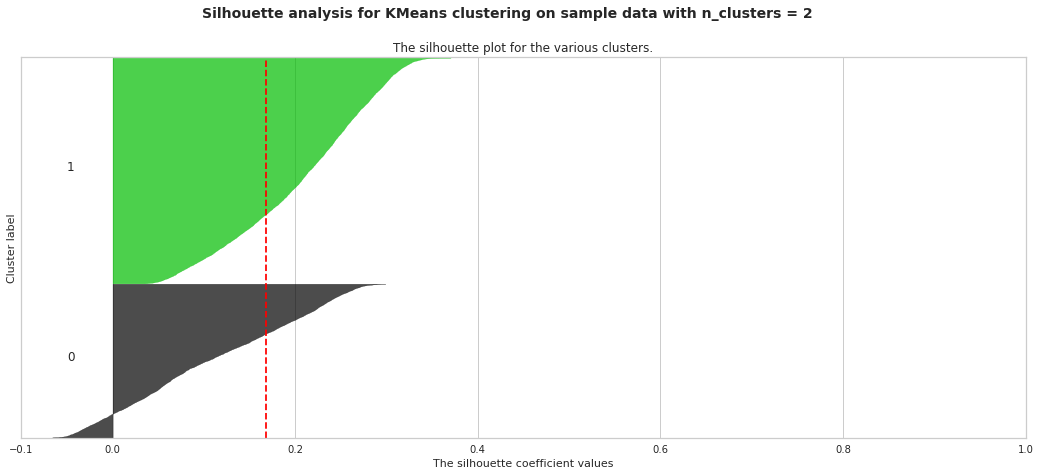

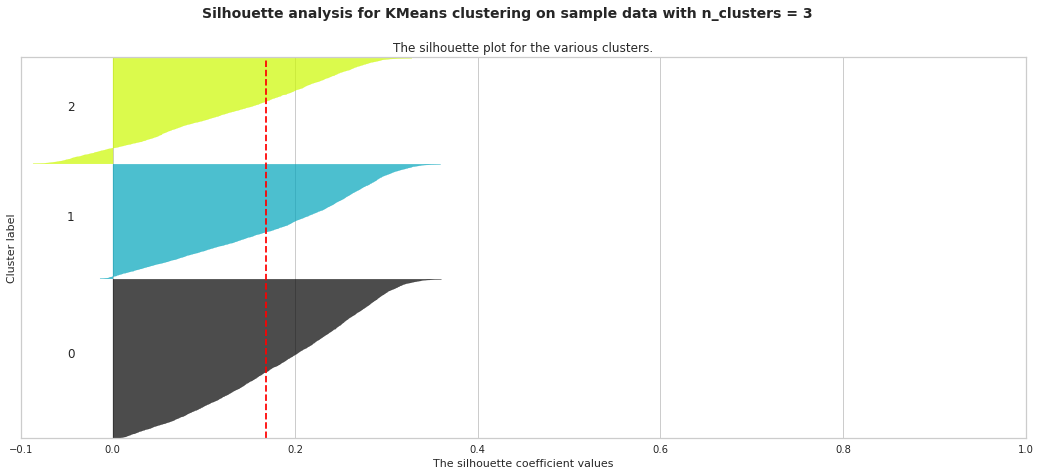

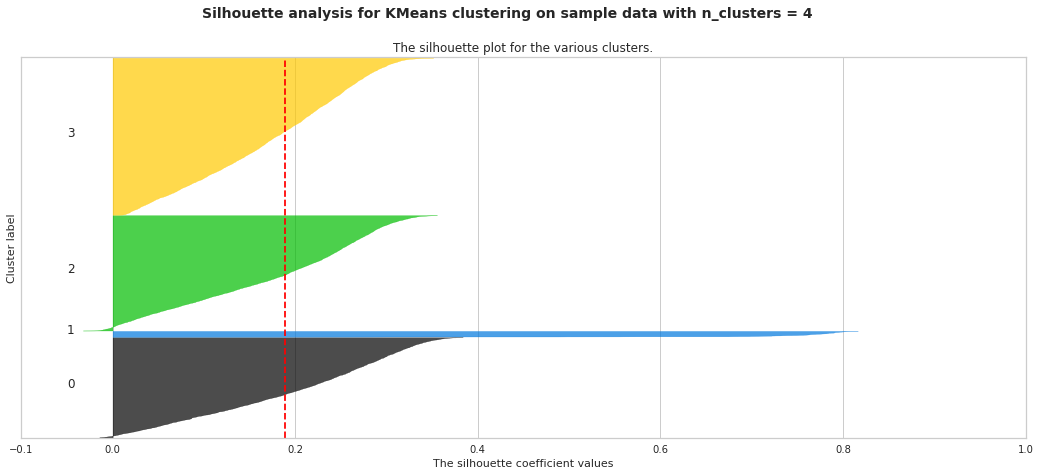

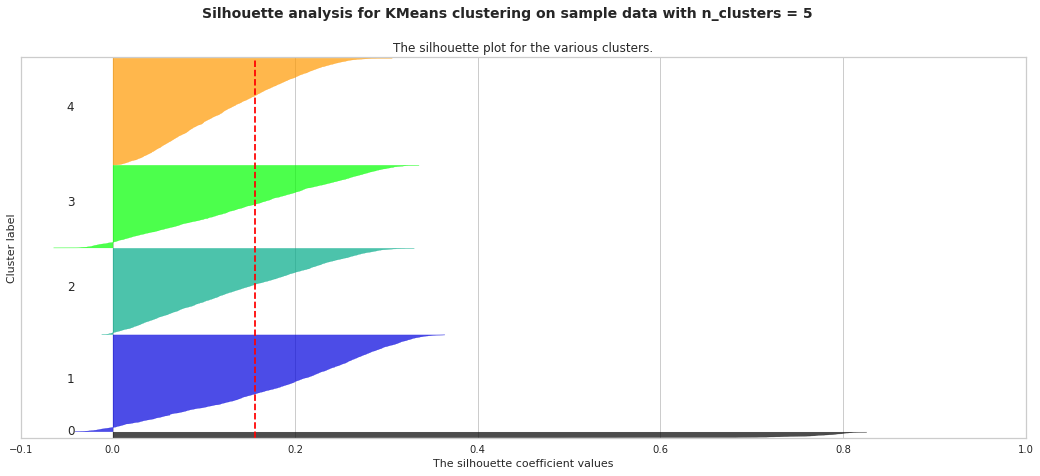

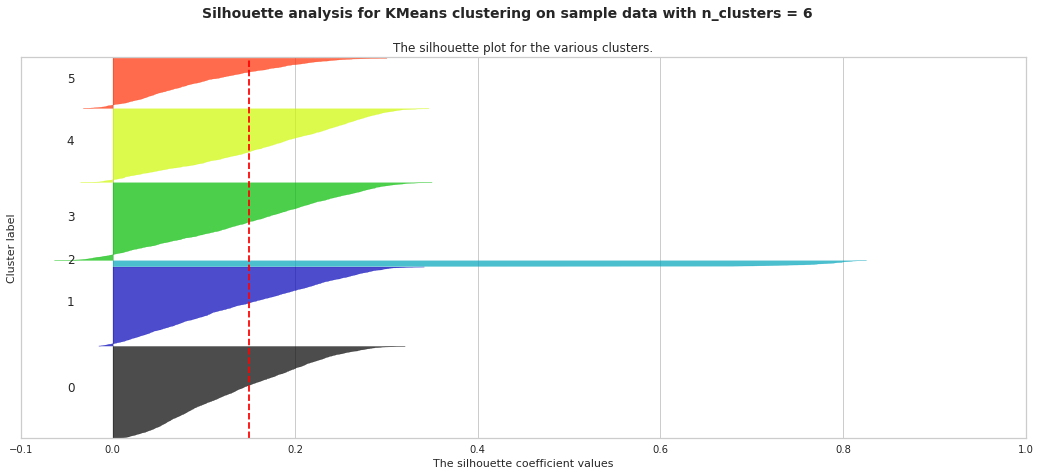

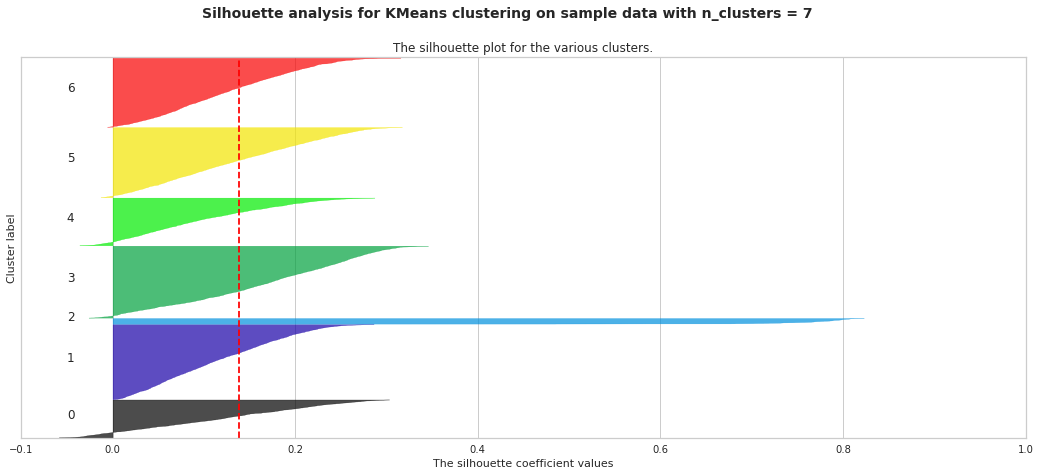

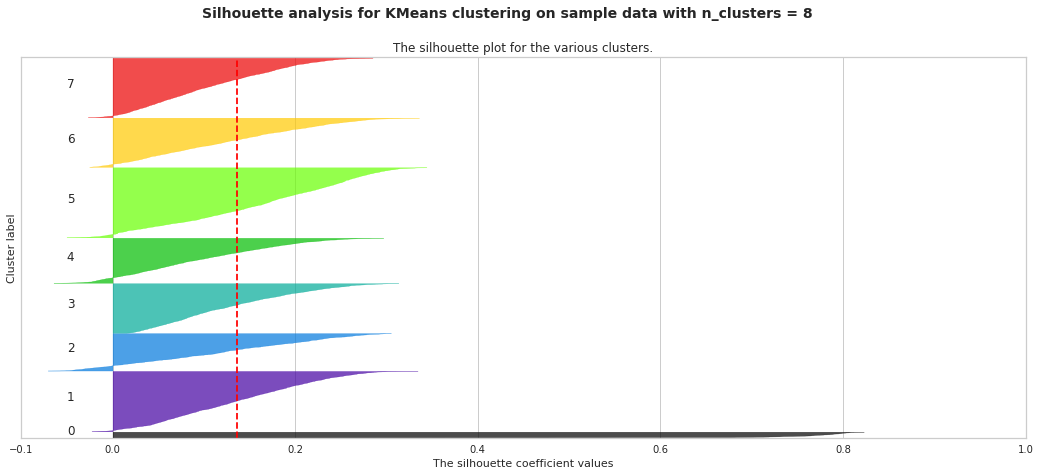

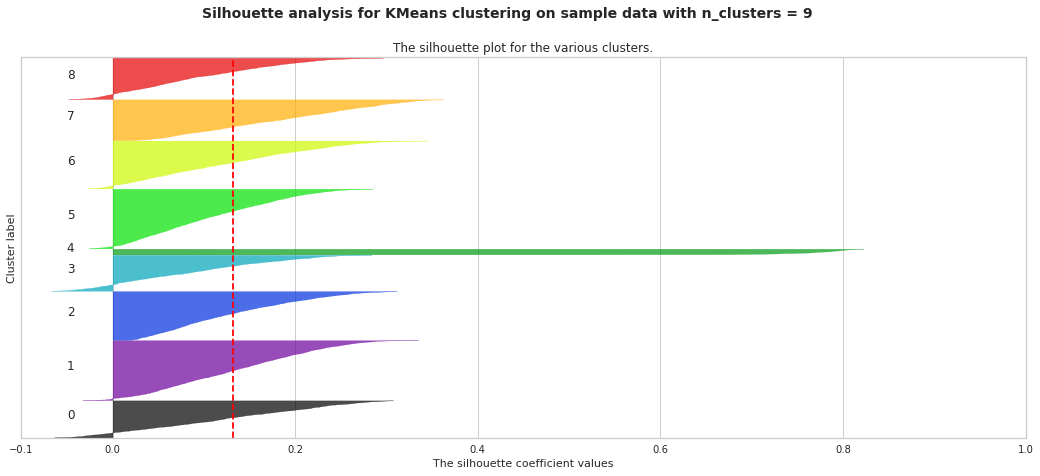

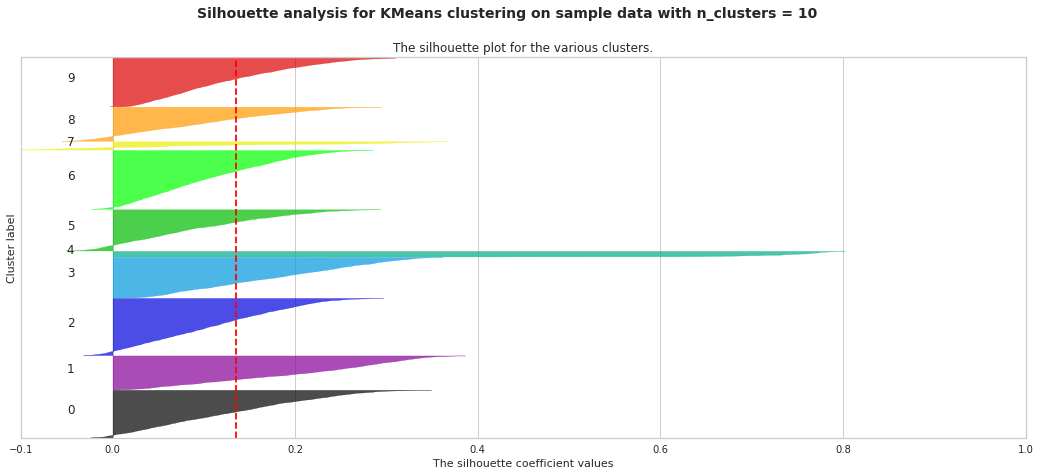

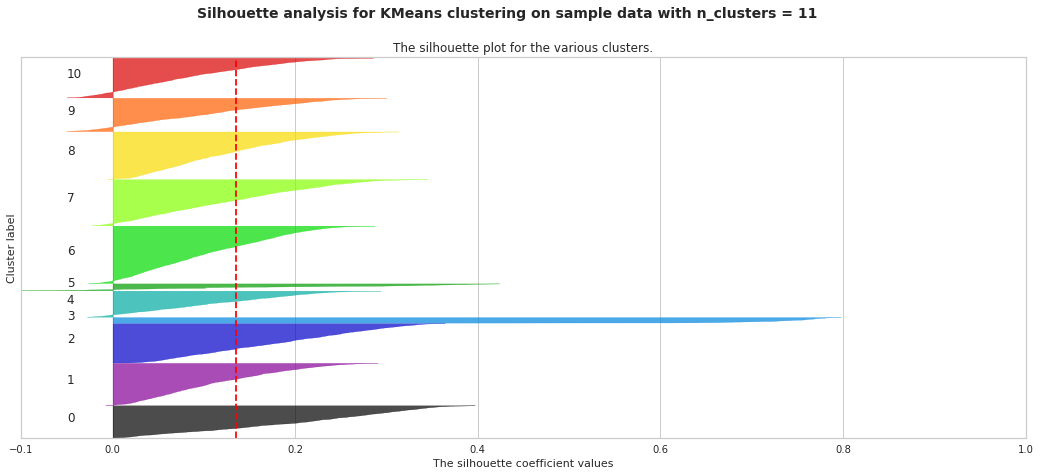

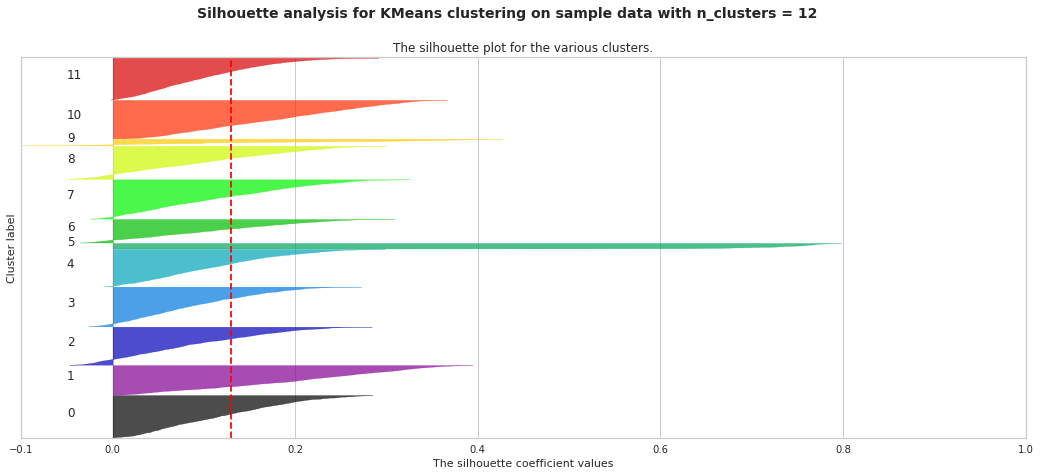

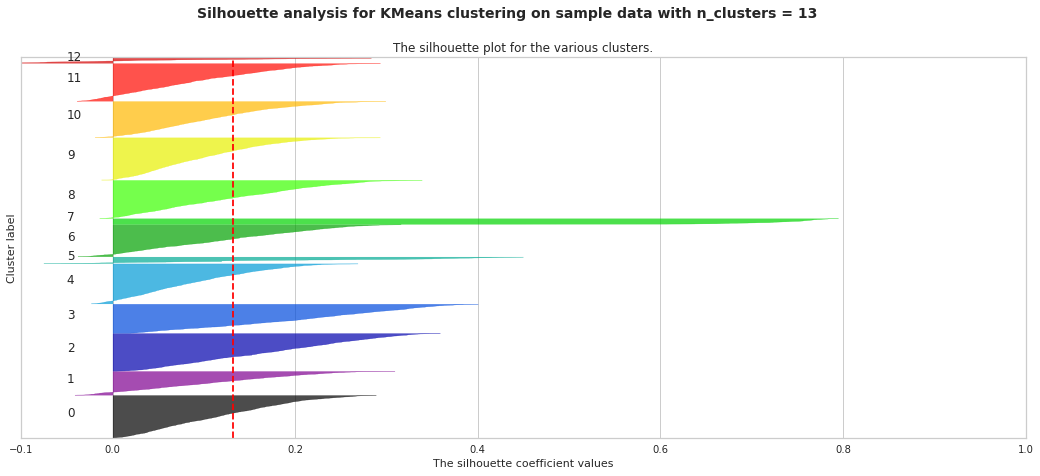

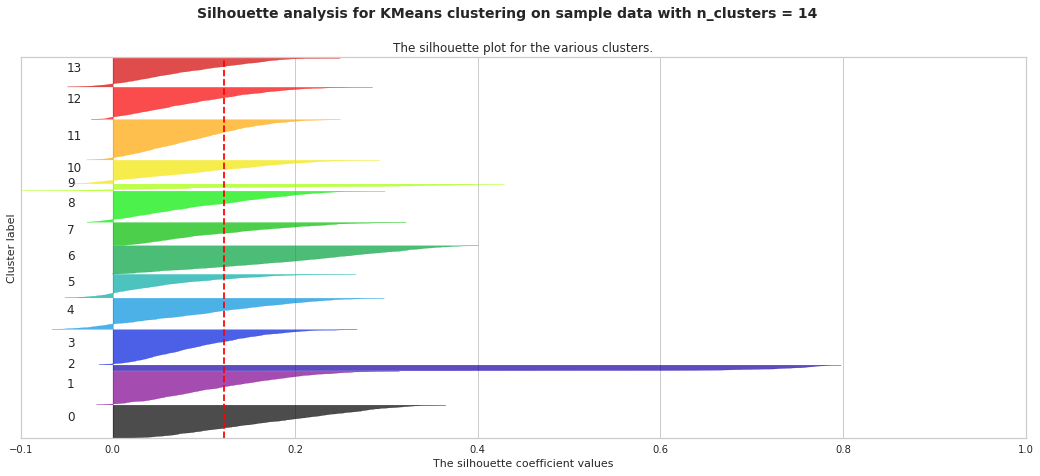

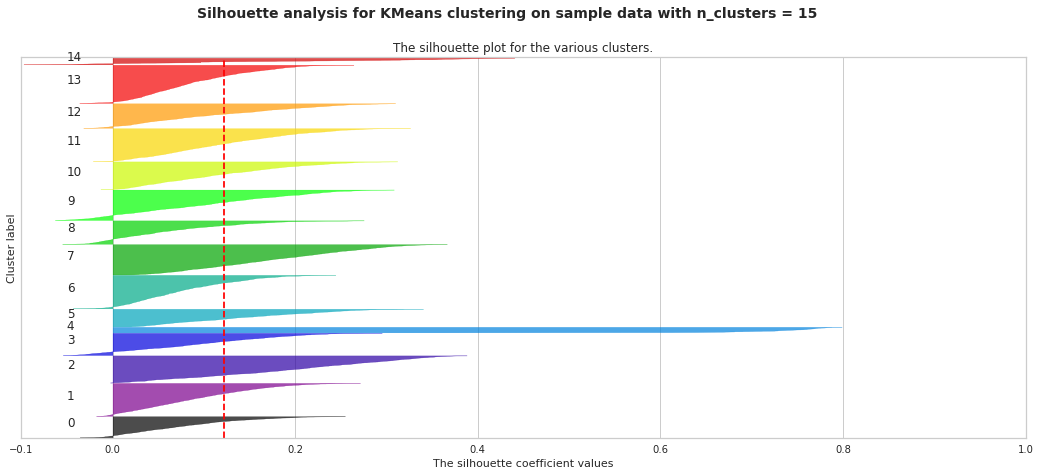

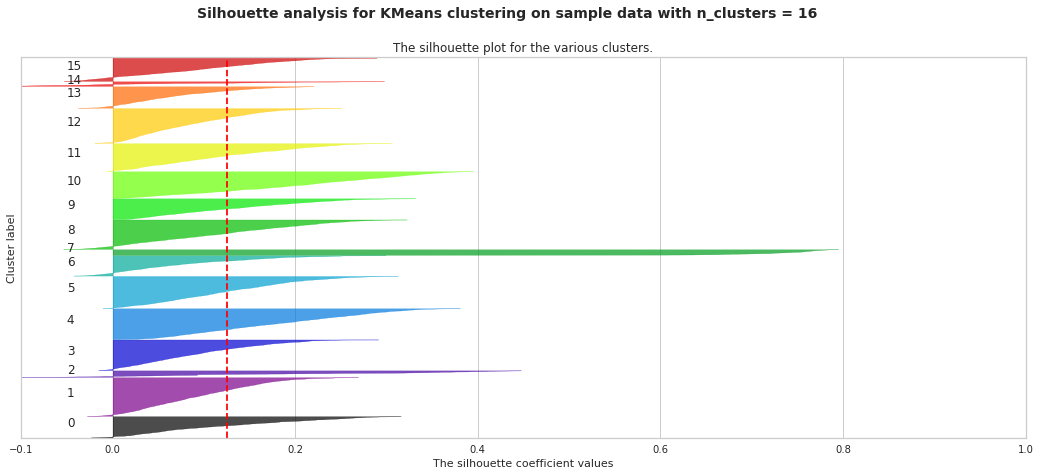

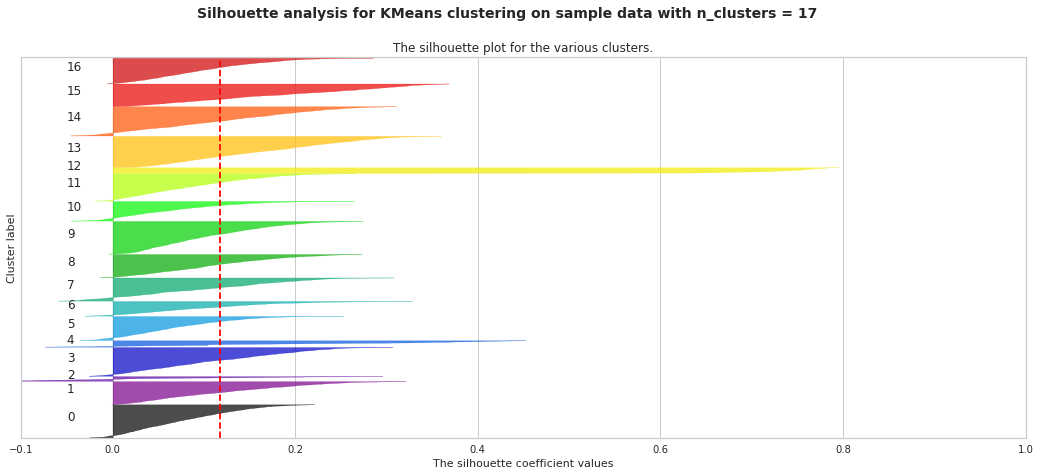

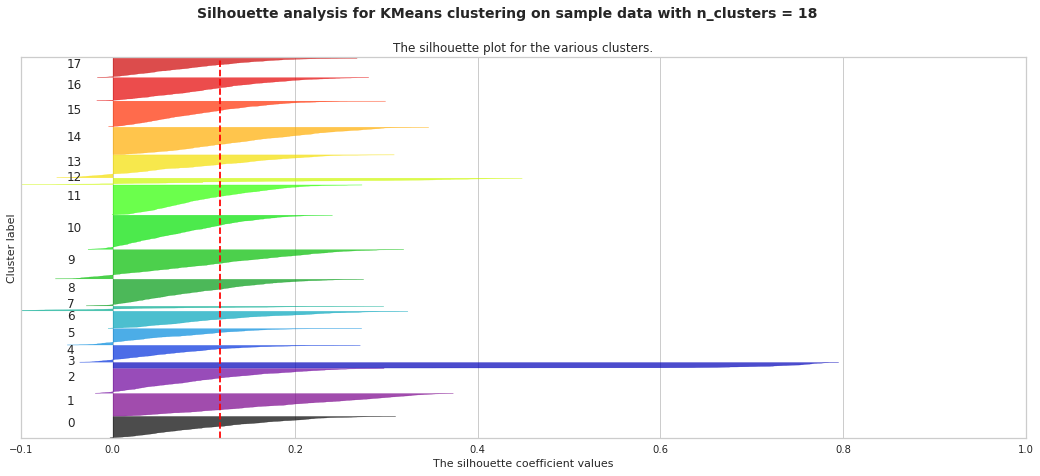

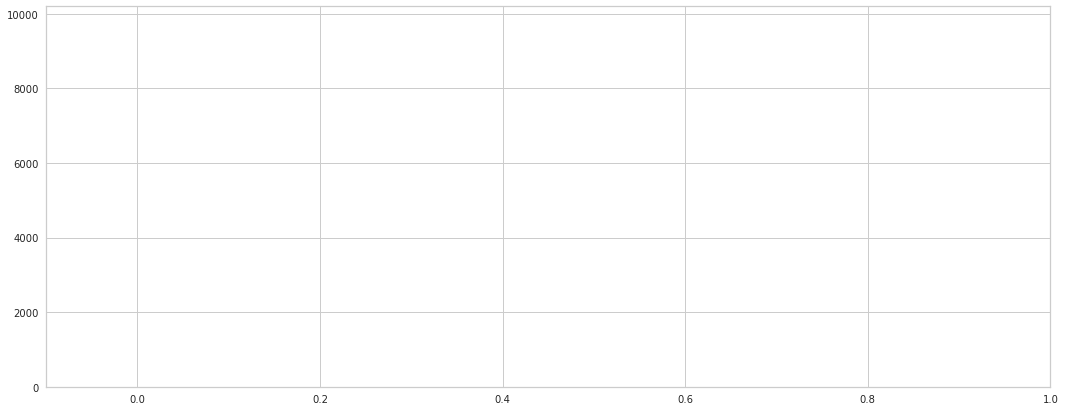

In [28]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X = vectors['word2vec_25_100'][np.random.choice(vectors['word2vec_25_100'].shape[0], 10000, replace=False), :]

range_n_clusters = list(range(2, 40))

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

AttributeError: 'KMeans' object has no attribute 'k'

AttributeError: 'KMeans' object has no attribute 'k'

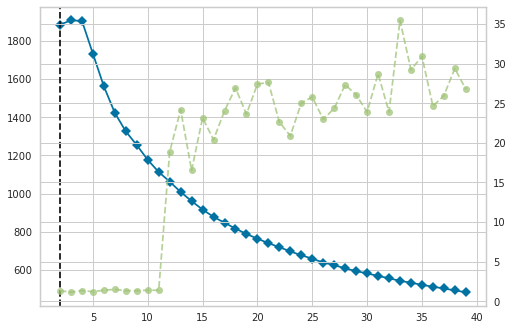

In [32]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 40), metric='calinski_harabasz')
visualizer.fit(sample)